In [1]:
import sys
sys.path.insert(0,"../")

In [17]:
import argparse

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger, MLFlowLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor, Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os
import torch

import matplotlib.pyplot as plt

import numpy as np

import wandb
api = wandb.Api()

from causalode import models, data_utils, cv_data_utils, covid_data_utils
from azureml.core.run import Run
from causalode.utils import str2bool

import scipy

sweeps = [api.sweep("edebrouwer/causalode/mrgxzm14"), api.sweep("edebrouwer/causalode/mqap3r2x")] # CV Neural ODE
dataset_cls_list= [ cv_data_utils.CVDataModule, covid_data_utils.CovidDataModule]
names = ["CV","Covid"]
repeats = 10

curve_cf_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_f_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_pehe_dict = {"random" : [], "propensity": [], "uncertainty": []}

def update_dict(main_dict, new_dict):
    for key in new_dict.keys():
        main_dict[key].append(new_dict[key])
        

Y_og_dict = {}
Y_ood_dict = {}
for isweep, sweep in enumerate(sweeps):
    run_names = [run.id for run in sweep.runs ]
    dataset_cls = dataset_cls_list[isweep]

    Y_og_list = []
    Y_ood_list = []
    for run_name in run_names:
        print(run_name)
        PATH = "./wandb/"
        paths = [p for p in os.listdir(PATH) if run_name in p]
        assert(len(paths)==1)
        PATH += paths[0] + "/files/causalode/"+run_name+"/checkpoints/"
        PATH+=os.listdir(PATH)[0]
        model_cls = models.VariationalSDE
        model = model_cls.load_from_checkpoint(PATH)

        hparams = dict(model.hparams)

        #dataset_cls = data_utils.PendulumDataModule
        #dataset_cls = covid_data_utils.CovidDataModule

        dataset = dataset_cls(**hparams)
        dataset.prepare_data()
        print(f"Loaded model and data from {PATH}")

        model.eval()

        with torch.no_grad():
            for i,batch in enumerate(dataset.test_dataloader()):
                X,Y, T, Y_cf, p, thetas_0 = batch
                times = torch.arange(11).float()
                #times = torch.arange(11).float()


                Y_hat_list = []
                for _ in range(repeats):
                    Y_hat, reg, logqp = model(X,T,return_decoded_u=True, times=times)
                    Y_hat_list.append(Y_hat[...,None])

                Y_hat_samples = torch.cat(Y_hat_list,-1)
                break


            X_ood = torch.rand(X.shape)#*0.5+2
            T_ood = T.clone()

            Y_hat_list_ood = []
            for _ in range(repeats):
                Y_hat_ood, reg, logqp = model(X_ood,T_ood,return_decoded_u=True, times=times)
                Y_hat_list_ood.append(Y_hat_ood[...,None])

            Y_hat_samples_ood = torch.cat(Y_hat_list_ood,-1)

        Y_og_list.append(Y_hat_samples)
        Y_ood_list.append(Y_hat_samples_ood)
    Y_og_dict[names[isweep]] = Y_og_list
    Y_ood_dict[names[isweep]] = Y_ood_list

6x55u2vb
Loaded model and data from ./wandb/run-20210824_125705-6x55u2vb/files/causalode/6x55u2vb/checkpoints/last.ckpt
b1jfzbjc
Loaded model and data from ./wandb/run-20210824_121148-b1jfzbjc/files/causalode/b1jfzbjc/checkpoints/last.ckpt
76reuo76
Loaded model and data from ./wandb/run-20210824_121202-76reuo76/files/causalode/76reuo76/checkpoints/epoch=19-step=139.ckpt
3ayimeon
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Loaded model and data from ./wandb/run-20210825_175003-3ayimeon/files/causalode/3ayimeon/checkpoints/last.ckpt
l7tdran6
Warning
Warning
Warning
Loaded model and data from ./wandb/run-20210825_174921-l7tdran6/files/causalode/l7tdran6/checkpoints/epoch=130-step=916.ckpt
xdqcdgy6
Warning
Warning
Warning
Warning
Warning
Warning
Loaded model and data from ./wandb/run-20210825_175005-xdqcdgy6/files/causalode/xdqcdgy6/checkpoints/last.ckpt


In [23]:
ood_dict = {}
og_dict ={}
for sim_type in names:
    Y_og_list = Y_og_dict[sim_type]
    Y_ood_list = Y_ood_dict[sim_type]
    for i in range(len(Y_og_list)):

    std_og = np.array([Y_og_list[i][0,:,:,:,:].std([-1,-2]).mean() for i in range(len(Y_og_list))])
    std_ood = np.array([Y_ood_list[i][0,:,:,:,:].std([-1,-2]).mean() for i in range(len(Y_ood_list))])
    
    ood_dict[sim_type] = std_ood / std_og.mean()
    og_dict[sim_type] = std_og / std_og.mean()

tensor(0.0453)
tensor(0.0576)
tensor(0.0493)
tensor(0.0685)
tensor(0.0450)
tensor(0.0468)
tensor(0.0294)
tensor(0.0392)
tensor(0.0181)
tensor(0.0237)
tensor(0.0247)
tensor(0.0354)


Text(0.5, 1.0, 'Comparison of uncertainty levels between in and out of distribution data')

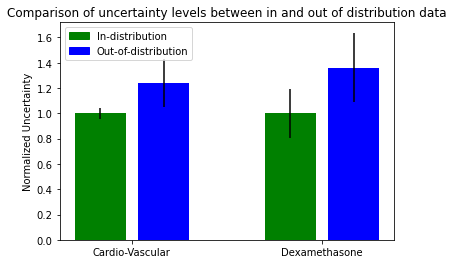

In [41]:
import matplotlib.pyplot as plt

og_vec = std_og / std_og.mean()

ood_vec = std_ood / std_og.mean()

plt.bar([0,0.5,1.5,2],[og_dict["CV"].mean(),ood_dict["CV"].mean(),og_dict["Covid"].mean(),ood_dict["Covid"].mean()],yerr=[og_dict["CV"].std(),ood_dict["CV"].std(),og_dict["Covid"].std(),ood_dict["Covid"].std()],width = 0.4, color = ["green","blue"])
plt.xticks([0.25,1.75],["Cardio-Vascular","Dexamethasone"])
plt.legend(["True","False"])

colors = {"In-distribution":"green", "Out-of-distribution":"blue"}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels,loc="upper left")
plt.ylabel("Normalized Uncertainty")
plt.title("Comparison of uncertainty levels between in and out of distribution data")